# Aprendizaje por refuerzo profundo - Libreta 9
*por Roberto-Esteban López*

Objetivos:
- Introducir a las políticas parametrizadas
- Implementar REINFORCE

## Aproximaciones sobre el espacio de políticas



En esta ocasion se utilizarán solamente los entornos de gym, y para aproximadores parametricos la librería de pytorch. Se puede cambiar el entorno de ejecución de esta libreta a GPU para acelerar algunas tareas de redes neuronales, pero esto es recomendable solamente para muchos datos y redes complejas.

In [ ]:
!pip install gif
!git clone https://github.com/Bobobert/RL_Toy
!pip install /content/RL_Toy/

In [ ]:
# Colab virtualDisplay for gym Environments
# This may not be necesary outside google colab
!sudo apt update
!apt install python-opengl
!apt install ffmpeg
!sudo apt-get install xvfb
!pip3 install pyvirtualdisplay

**Para Colab es necesario reiniciar el entorno después de ejecutar la celda de arriba**

In [ ]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1280, 720))
virtual_display.start()

In [ ]:
# Importar librerias
## Algebra y  graficas
import matplotlib.pyplot as plt
import numpy as np

## GYM 
from gym import make

## Pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.distributions import Categorical

## RL_Toy
from RL_Toy.utils import render, runPolicy, runEnv

Creamos un nuevo entorno de gym, los siguientes ejericicios estan pensandos en los incluidos en la categoria "classic control".

In [ ]:
env = make("CartPole-v0")

Mean accumulate Reward 15.17, episodes 6


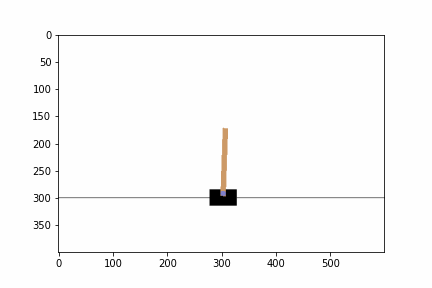

In [ ]:
runEnv(env, 100)

#### Políticas con Pytorch

Pytorch es una libreria que facilita ampliamente el fácil prototipado de algoritmos de aprendizaje de redes neuronales, con implementaciones de bajo nivel que acelera el rendimiento contra el uso de python nativo, pero aun usando la misma interfaz.

Esta vez se define una nueva clase política para introducir métodos necesarios al usar una función para aproxoimar la función de la política misma.


In [ ]:
def numpyFlat(d):
    d = torch.as_tensor(d, dtype=torch.float32)
    d = d.unsqueeze(0).flatten(1)
    return d

class Policy(nn.Module):
    """
    Base class to define a parametric policy for 
    policy methods in pytorch
    """
    def __init__(self):
        super(Policy, self).__init__()
        self._name_ = "Parametric policy neural network"

    def forward(self, X):
        raise NotImplementedError

    def getDist(self, output):
        """
        This method should construct a distribution given an output
        of the network. This could be any shape or kind. 
        
        Should expect a batch of outputs too.

        parameters
        ----------
        output: torch.Tensor

        returns
        ----------
        distribution: torch.distributions.distribution.Distribution
        """
        raise NotImplementedError

    def infere(self, obs):
        """
        Given an observation, calculates accordingly the 
        corresponding action. If exploration is in order do
        not implement it here.

        parameters
        -----------
        obs: torch.Tensor

        returns
        -----------
        action: int, log_prob: torch.Tensor
        """
        output = self.forward(obs)
        dist = self.getDist(output)
        actions = dist.sample()
        log_actions = dist.log_prob(actions)

        return actions, log_actions

    def getAction(self, obs):
        """
        Method to return the action given the observation
        given as a tensor from the environment.

        parameters
        ----------
        obs: torch.tensor

        output
        ------
        action: torch.tensor 
        """
        if isinstance(obs, np.ndarray):
            obs = numpyFlat(obs)
        actions, _ = self.infere(obs)
        return actions.item()
    

Traemos funciones adicionales nuevas y ya usadas previamente en las libretas pasadas.


In [ ]:
def evaluatePolicy(env, policy, samples:int = 30):
    res = []
    policy.test = True
    for _ in range(samples):
        obs = env.reset()
        done = False
        G = 0
        while not done:
            # Each step on the episode
            action = policy.getAction(obs)
            obs, reward, done, info = env.step(action)
            G += reward
        res += [G]
    policy.test = False
    return np.mean(res), np.std(res)

def graphResults(means, stds, testFreq, mod:str, dpi=200):
    mean = np.array(means)
    stds = np.array(stds)
    fig = plt.figure(dpi=dpi)
    plt.title("{}: Accumulated Reward per Episode".format(mod))
    plt.xlabel("Episode")
    plt.ylabel("Accumulate Reward")
    x = np.arange(0,len(means)*testFreq, testFreq)
    plt.plot(x, means, label = "Accumulate Reward", lw = 2)
    plt.fill_between(x, means - stds, means + stds, alpha = 0.1)


In [ ]:
def crawler_policy(env, policy, gamma):
    """
    Trajectory sampler for pytorch policy approximation

    parameters
    ----------
    env: The environment
        gym environment
    policy: pytorch policy
        Must have method .infere(obs)
    gamma: float
        Discount factor

    returns
    --------
    obs: torch.tensor
        Observations from the environment
    actions: torch.tensor
        action sampled
    log_actions: torch.tensor
        The log of the probability for the action taken
        log pi (a|s)
    returns: torch.tensor
        The return at given time
    """
    obs = env.reset()
    done = False
    observations, actions, rewards, Gs, log_actions = [], [], [], [], []
    while not done:
        # Convert observation to torch.tensor
        obs = numpyFlat(obs)
        # Sample an action from the policy
        action, log_action = policy.infere(obs)
        # Add to the lists
        observations += [obs]
        actions += [action]
        log_actions += [log_action]
        # Step on the environment
        obs, reward, done, _ = env.step(action.item())
        # Add the reward seen
        rewards += [reward]
        Gs += [0.0]
    # Calculate the returns
    Gs[-1] = rewards[-1]
    for i in range(len(Gs) - 2, -1, -1):
        Gs[i] = rewards[i] + gamma * Gs[i + 1]
    # Prepare tensors
    observations = torch.cat(observations, dim = 0)
    actions = torch.cat(actions, dim = 0)
    log_actions = torch.cat(log_actions, dim = 0)
    Gs = procssObs(policy, Gs).unsqueeze(1)
    return observations, actions, log_actions, Gs

def procssObs(policy, obs):
    obs = [torch.as_tensor(i).unsqueeze(0).float() for i in obs]
    return torch.cat(obs, dim=0)

Con estas funciones, y pensando en particular en el entorno que se tiene cuyo espacio de acciones es discreto. Se escribe la primera función de política.

In [ ]:
class discretePolicy(Policy):
    _h1_ = 52
    def __init__(self, inputs: int, actions: int):
        assert inputs > 0, "Inputs need to be greater than zero"
        assert actions > 0, "Actions need to be greater than zero"
        super(discretePolicy, self).__init__()
        self.rectifier = F.relu
        self.fc1 = nn.Linear(inputs, self._h1_)
        self.fc2 = nn.Linear(self._h1_, actions)

    def forward(self, X):
        X = self.rectifier(self.fc1(X))
        return self.fc2(X)
    
    def getDist(self, output):
        return Categorical(logits = output)

In [ ]:
pi = discretePolicy(inputs = 4, actions = 2)
print("Policy: Mean {}, std {}".format(*evaluatePolicy(env, pi, 10**2)))

Policy: Mean 21.68, std 11.764250932379843


In [ ]:
optimizer = optim.Adam(pi.parameters(), 1e-4)

### REINFORCE Monte-Carlo

In [ ]:
def Reinforce(env, policy, optimizer,
            episodes:int, freqTest: int,
            gamma:float = 0.99, batchSize: int = 32
            ):
    """
    Vanilla REINFORCE implementation in pytorch

    parameters
    -----------
    env: Environment object
        The environment object we are deling with. Action space type Discrete
    policy: pytorch policy
        The policy to evaluate.
    optimizer: pytorch optimizer
        An optimizer object
    epsidodes: integer > 0
        Total number of episodes to run the policy and to improve from
    gamma: float
        Discount factor
    freqTest: integer > 0
        The frequency in which a test to evaluate the policy performance is done
    """

    assert (gamma <= 1) and (gamma >= 0), "Gamma must be in the interval [0,1] "
        
    testMean, testStd  = [], []
    # Episode loop
    for it in range(episodes):

        # Checking and executing test
        if it % freqTest == 0:
            meanG, stdG = evaluatePolicy(env, policy)
            testMean += [meanG]
            testStd += [stdG]
            print("Episode {} done. Test : Mean {} Std {}".format(it, meanG, stdG))

        # Do trajectory tau with policy
        obs , actions, log_actions, returns = crawler_policy(env, policy, gamma)

        # -1.0 is important here as the optimizer applies to minimization
        lossPolicy = -1.0 * torch.sum(torch.mul(log_actions, returns))

        # Apply loss
        optimizer.zero_grad()
        lossPolicy.backward()
        optimizer.step()
    
    graphResults(testMean, testStd, freqTest, mod = "REINFORCE Vanilla")

Episode 0 done. Test : Mean 22.366666666666667 Std 12.229699732845264
Episode 1000 done. Test : Mean 34.9 Std 23.969911695011866
Episode 2000 done. Test : Mean 38.8 Std 20.897208745029406
Episode 3000 done. Test : Mean 46.96666666666667 Std 30.621869454507326
Episode 4000 done. Test : Mean 63.93333333333333 Std 39.896477148852235
Episode 5000 done. Test : Mean 88.7 Std 49.80371472089206
Episode 6000 done. Test : Mean 127.96666666666667 Std 57.01256196858918
Episode 7000 done. Test : Mean 160.4 Std 46.014925114937796
Episode 8000 done. Test : Mean 176.7 Std 29.840855662441495
Episode 9000 done. Test : Mean 171.53333333333333 Std 36.82728457121009


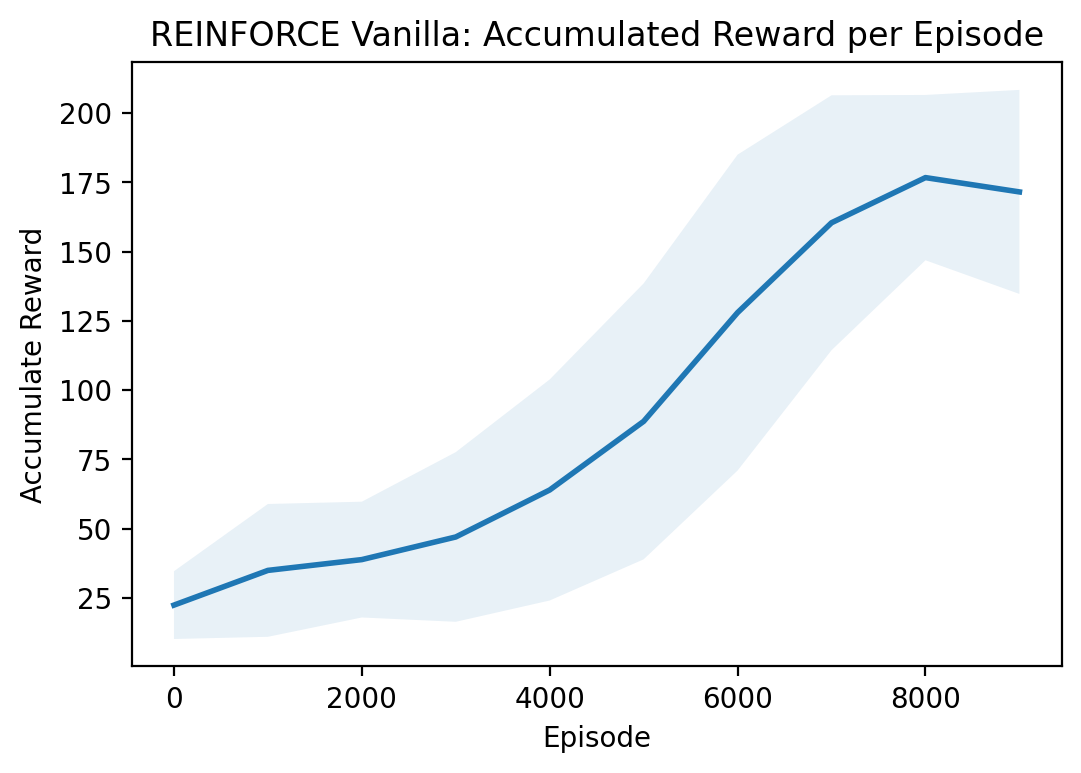

In [ ]:
Reinforce(env, pi, optimizer, 10**4, 10**3)

In [ ]:
print("Policy: Mean {}, std {}".format(*evaluatePolicy(env, pi, 10**2)))

Policy: Mean 178.68, std 36.768160138902786


In [ ]:
runPolicy(env, pi, 200)

Output hidden; open in https://colab.research.google.com to view.

### REINFORCE con Baseline

Los resultados anteriores son actualizando la política con un update proporcional a ganancia de la política. Este resultado bien no tiene sesgo (bias), podría tener bien una varianza elevada. Para compensar este hecho, se puede agregar una función *baseline* que no introduzca sesgo pero si ayude a bajar la varianza (¿por qué pasa esto?). 
La función candidata para esto es una función aproximadora de los estado-valor $V(s) \approx \mathbb{E}_\pi [G_t]$

Primero se define una clase base para la función estado-valor aproximada.

In [ ]:
class Value(nn.Module):
    """
    Base class for a value function approximator.
    """
    def __init__(self):
        super(Value, self).__init__()
        self._name_ = "Parametric value function"

    def forward(self, X):
        raise NotImplementedError

In [ ]:
class baselineNet(Value):
    _h1_ = 52
    def __init__(self, inputs:int):
        assert inputs > 0, "Inputs need to be greater than zero"
        super(baselineNet, self).__init__()
        self.rectifier = F.relu
        self.fc1 = nn.Linear(inputs, self._h1_)
        self.fc2 = nn.Linear(self._h1_, 1)

    def forward(self, X):
        X = self.rectifier(self.fc1(X))
        return self.fc2(X)

In [ ]:
def Reinforce_baseline(env, policy, optPi,
                baseline, optB,
                episodes:int, freqTest: int,
                gamma:float = 0.99, batchSize:int = 32
                ):
    """
    Vanilla REINFORCE implementation in pytorch

    parameters
    -----------
    env: Environment object
        The environment object we are deling with. Action space type Discrete
    policy: pytorch policy
        The policy to evaluate.
    optPi: pytorch optimizer
        An optimizer object for the policy parameters
    baseline: pytorch Value
        The value fuction approximation for the environment
    optB: pytorch optimizer
        An optimizer object for the baseline parameters
    epsidodes: integer > 0
        Total number of episodes to run the policy and to improve from
    gamma: float
        Discount factor
    freqTest: integer > 0
        The frequency in which a test to evaluate the policy performance is done
    """

    assert (gamma <= 1) and (gamma >= 0), "Gamma must be in the interval [0,1] "
        
    testMean, testStd  = [], []
    # Episode loop
    for it in range(episodes):

        # Checking and executing test
        if it % freqTest == 0:
            meanG, stdG = evaluatePolicy(env, policy)
            testMean += [meanG]
            testStd += [stdG]
            print("Episode {} done. Test : Mean {} Std {}".format(it, meanG, stdG))

        # Do trajectory tau with policy
        obs , actions, log_actions, returns = crawler_policy(env, policy, gamma)

        # Calculate returns and advantages for tau
        baselines = baseline.forward(obs)
        # what's an advantage?
        advantages = returns - baselines.detach()

        # Policy update
        ## Calculate loss

        ## -1.0 is important here as the optimizer applies to minimization
        lossPolicy = -1.0 * torch.sum(torch.mul(log_actions, advantages))

        ## Apply loss
        optPi.zero_grad()
        lossPolicy.backward()
        optPi.step()

        lossBaseline = torch.nn.functional.mse_loss(baselines, returns)
        # Baseline update
        optB.zero_grad()
        lossBaseline.backward()
        optB.step()

    graphResults(testMean, testStd, freqTest, mod = "REINFORCE baseline")

In [ ]:
# New policy
pi_b = discretePolicy(inputs = 4, actions = 2)
optPi = optim.Adam(pi_b.parameters(), 1e-4)

baseline = baselineNet(inputs= 4)
optB = optim.Adam(baseline.parameters(), 1e-4)

In [ ]:
print("Policy: Mean {}, std {}".format(*evaluatePolicy(env, pi_b, 10**2)))

Policy: Mean 20.61, std 10.466990971621213


Episode 0 done. Test : Mean 22.166666666666668 Std 9.409510555224903
Episode 1000 done. Test : Mean 32.8 Std 14.325734419800847
Episode 2000 done. Test : Mean 33.7 Std 18.268643445350104
Episode 3000 done. Test : Mean 45.56666666666667 Std 22.13847831767627
Episode 4000 done. Test : Mean 45.3 Std 21.28716358121329
Episode 5000 done. Test : Mean 54.8 Std 25.11493579525936
Episode 6000 done. Test : Mean 69.9 Std 40.781817844067064
Episode 7000 done. Test : Mean 108.66666666666667 Std 55.77653827750717
Episode 8000 done. Test : Mean 139.16666666666666 Std 56.98835163629689
Episode 9000 done. Test : Mean 163.83333333333334 Std 45.15682549614054


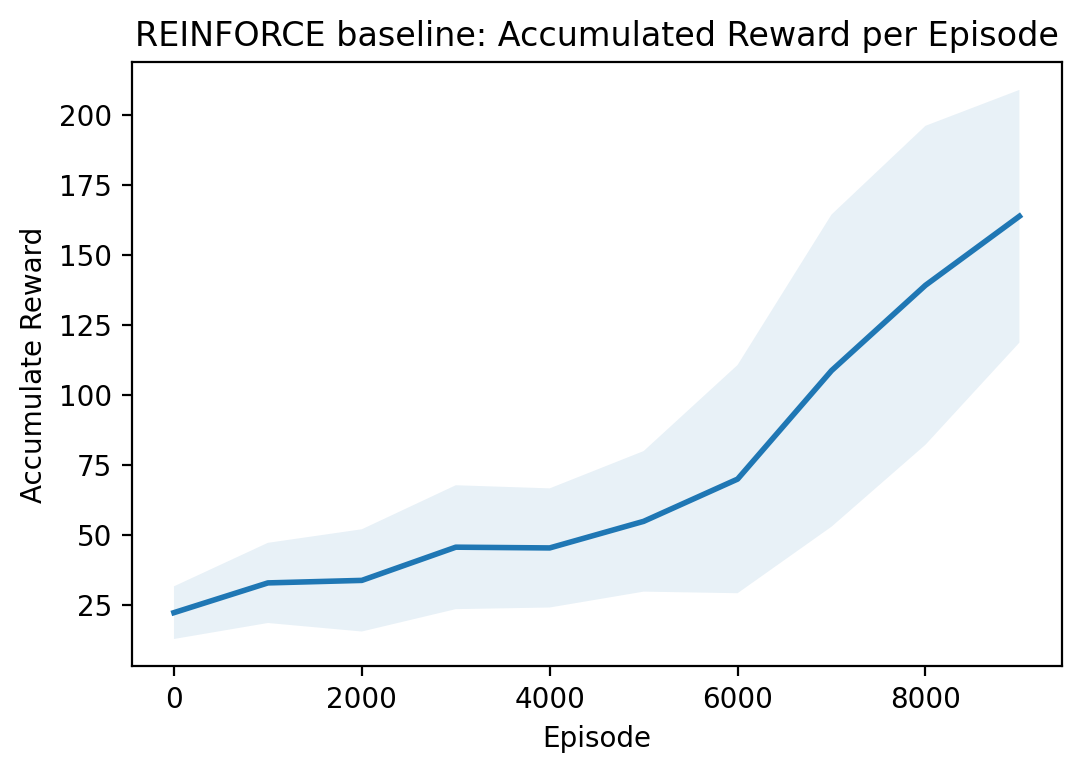

In [ ]:
Reinforce_baseline(env, pi_b, optPi, baseline, optB,
                   10**4, 10**3)

In [ ]:
print("Policy: Mean {}, std {}".format(*evaluatePolicy(env, pi_b, 10**2)))

Policy: Mean 164.36, std 42.22854958437478
